### IEMS 394

#### Data Pipeline
Objective: Load and clean data, save as pickle.

In [17]:
%%time
import matplotlib.pyplot as plt
from shapely.geometry import shape, Point, Polygon
import pandas as pd
from tqdm import tqdm
import os, geojson, multiprocessing, datetime, time
import concurrent.futures
# %matplotlib tk

os.chdir('/Users/saifbhatti/Desktop/Northwestern/sy1920/s20/iems394/client-data/cleaned_data')

with open('us_counties_2010.json', encoding = "ISO-8859-1") as f:
    gj = geojson.load(f)
selected_states = ['TX','CA','MN']

CPU times: user 1.95 s, sys: 68.3 ms, total: 2.02 s
Wall time: 2.02 s


### Vision (end goals)

- Data Cleaning (python file) 
    - read in appropriate csv files that have been cleaned
    - convert to dataframe
    - pickle
- AMPL szn (python file)
    - unpickle
    - AMPLpy code that uses the dataframes as decision parameters
- Visualisation (ipynb)
    - either 

### Files

Vehicle Data:
- EV_Ranges.csv
- vehicle_ages.csv
- vehicles_available.csv
- trip_purpose_miles.csv
- HI_vehicles.csv
- HEV_model-sales.csv
- PEV_model-sales.csv
- Distance.csv



#### Import and Clean Vehicle Data

In [18]:
df = pd.read_csv('HEV_model-sales.csv',skiprows=1,thousands=',')
df.drop('Total',axis=1,inplace=True)
df.drop(df.index[df.shape[0]-1],inplace=True)
df.set_index(df['Vehicle'],inplace=True)
df.drop('Vehicle',axis=1,inplace=True)
df = df.applymap(lambda x: x.replace('-','0'))
df = df.applymap(lambda x: x.replace(",", ""))
# df = df.applymap(lambda x: x=int(x))
cols=[i for i in df.columns if i not in ['Vehicle']]
for col in cols:
    df[col]=pd.to_numeric(df[col])
hybrid_df = df

In [19]:
hybrid_df['total']= hybrid_df.sum(axis=1) #total sum per column
# hybrid_df['total'].plot(kind='bar',x='name',y='sales volume')
# hybrid_df

In [91]:
df = pd.read_csv('PEV_model-sales.csv',skiprows=1,thousands=',')
df.drop('Total',axis=1,inplace=True)
df.drop(df.index[df.shape[0]-1],inplace=True)
df.set_index(df['Vehicle'],inplace=True)
df.drop('Vehicle',axis=1,inplace=True)
# df.replace(to_replace='-',value=';')
df = df.applymap(lambda x: x.replace('-','0'))
df = df.applymap(lambda x: x.replace(",", ""))
cols=[i for i in df.columns if i not in ['Type']]
for col in cols:
    df[col]=pd.to_numeric(df[col])
electric_df = df

In [96]:
EV_ranges_df =  pd.read_csv('EV_ranges.csv')
EV_ranges_df['Range'].mean()

109.3076923076923

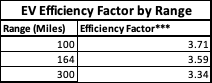

In [22]:
df = pd.read_csv('electric_fuel_stations.csv')
electric_fuel_df = df
df.head()

,Unnamed: 0,Fuel Type Code,Station Name,Street Address,City,State,County,ZIP,Status Code,Groups With Access Code,...,Date Last Confirmed,ID,Owner Type Code,Open Date,EV Connector Types,Country,Access Code,Facility Type,EV Pricing,EV On-Site Renewable Source
0,0,ELEC,City of Sacramento - Capitol Parking Garage,1015 L St,Sacramento,CA,Sacramento,95814,E,Public,...,05/09/2019,1498,LG,8/20/2018,NEMA520,US,public,PAY_GARAGE,NaN,NaN
1,1,ELEC,LADWP - Truesdale Center,11797 Truesdale St,Sun Valley,CA,Los Angeles,91352,E,Private,...,1/13/2020,1517,LG,10/15/1999,J1772,US,private,UTILITY,NaN,NaN
2,2,ELEC,Southern California Edison - Rosemead Office B...,2244 Walnut Grove Ave,Rosemead,CA,Los Angeles,91770,E,Private,...,1/13/2020,1520,T,08/01/2011,J1772 NEMA520,US,private,UTILITY,NaN,NaN
3,3,ELEC,Los Angeles Convention Center,1201 S Figueroa St,Los Angeles,CA,Los Angeles,90015,E,Public,...,05/09/2019,1523,P,8/30/1995,J1772,US,public,PARKING_GARAGE,NaN,NaN
4,4,ELEC,LADWP - John Ferraro Building,111 N Hope St,Los Angeles,CA,Los Angeles,90012,E,Private,...,1/13/2020,1525,LG,10/15/1999,J1772,US,private,UTILITY,NaN,NaN


In [23]:
# df['point'] = df['Longitude'] + df['Latitude']
df['Points'] = list(zip(df['Longitude'], df['Latitude']))
# df.tail(20)
df.head()

,Unnamed: 0,Fuel Type Code,Station Name,Street Address,City,State,County,ZIP,Status Code,Groups With Access Code,...,ID,Owner Type Code,Open Date,EV Connector Types,Country,Access Code,Facility Type,EV Pricing,EV On-Site Renewable Source,Points
0,0,ELEC,City of Sacramento - Capitol Parking Garage,1015 L St,Sacramento,CA,Sacramento,95814,E,Public,...,1498,LG,8/20/2018,NEMA520,US,public,PAY_GARAGE,NaN,NaN,"(-121.4926, 38.578380200000005)"
1,1,ELEC,LADWP - Truesdale Center,11797 Truesdale St,Sun Valley,CA,Los Angeles,91352,E,Private,...,1517,LG,10/15/1999,J1772,US,private,UTILITY,NaN,NaN,"(-118.38797140000001, 34.24831915)"
2,2,ELEC,Southern California Edison - Rosemead Office B...,2244 Walnut Grove Ave,Rosemead,CA,Los Angeles,91770,E,Private,...,1520,T,08/01/2011,J1772 NEMA520,US,private,UTILITY,NaN,NaN,"(-118.081014, 34.050745)"
3,3,ELEC,Los Angeles Convention Center,1201 S Figueroa St,Los Angeles,CA,Los Angeles,90015,E,Public,...,1523,P,8/30/1995,J1772,US,public,PARKING_GARAGE,NaN,NaN,"(-118.26876200000001, 34.04057)"
4,4,ELEC,LADWP - John Ferraro Building,111 N Hope St,Los Angeles,CA,Los Angeles,90012,E,Private,...,1525,LG,10/15/1999,J1772,US,private,UTILITY,NaN,NaN,"(-118.24819, 34.058476)"


In [24]:
def geo_map(x):
    '''
    geo_map takes pandas Series object constructed in the format (longitude, latitude).
    Taking this as the point, a geo.json file is imported containing all US counties from the 2010 census as polygons.
    It computes whether the point is within a polygon, and returns a list of all matches. 
    If a point is not matched, it returns None.
    '''
    point = Point(x)
    for i in range(len(gj['features'])):
        polygon = shape(gj['features'][i]['geometry'])
        if polygon.contains(point):
            return gj['features'][i]['properties']['NAME']

In [25]:
def geo_two(x):
    '''
    geo_map takes pandas Series object constructed in the format (longitude, latitude).
    Taking this as the point, a geo.json file is imported containing all US counties from the 2010 census as polygons.
    It computes whether the point is within a polygon, and returns a list of all matches. 
    If a point is not matched, it returns None.
    '''
    counties = []
    for i in tqdm(x):
        point = Point(x)
        for i in range(len(gj['features'])):
            polygon = shape(gj['features'][i]['geometry'])
            if polygon.contains(point):
                counties.append(gj['features'][i]['properties']['NAME'])

In [26]:
counties = []
points_list = list(df['Points'])
# for i in tqdm(points_list):
#     counties.append(geo_map(i)) #takes 40 minutes to run

In [27]:
# electric_fuel_df['County'] = counties

In [28]:
# electric_fuel_df.to_csv('electric_fuel_stations.csv')

In [29]:
# electric_fuel_df

In [30]:
# electric_df.to_pickle("./dummy.pkl")

### Convert data from zipcode to county.

In [31]:
tx_ev_vehicle_registered = pd.read_csv('vehicle_reg/tx_ev_registrations_public.csv')
print(len(tx_ev_vehicle_registered['ZIP Code'].unique()))
print(len(tx_ev_vehicle_registered))
tx_ev_vehicle_registered.head()

1325
74143


,ZIP Code,DMV ID,Vehicle Name,Registration Valid Date
0,3106,1,Tesla Model S,03/06/2019
1,3106,1,Tesla Model S,03/06/2019
2,3106,1,Tesla Model S,03/06/2019
3,3106,1,Tesla Model S,03/06/2019
4,3106,1,Tesla Model S,03/06/2019


In [32]:
mn_ev_vehicle_registered = pd.read_csv('vehicle_reg/mn_ev_registrations_public.csv')
mn_ev_vehicle_registered.drop(['VIN Prefix','VIN Model Year'],inplace=True,axis=1)
print(len(mn_ev_vehicle_registered['ZIP Code'].unique()))
print(len(mn_ev_vehicle_registered))
mn_ev_vehicle_registered.head()

600
29248


,DMV ID,ZIP Code,Registration Expiration Date,Registration Valid Date
0,6,55347.0,01/12/2020,30/01/2020
1,6,55432.0,01/12/2020,30/01/2020
2,6,55330.0,01/07/2020,30/01/2020
3,6,56377.0,01/04/2020,30/01/2020
4,6,55109.0,01/12/2020,30/01/2020


In [33]:
result = pd.concat([mn_ev_vehicle_registered, tx_ev_vehicle_registered], axis=0)
print(len(result['ZIP Code'].unique()))
print(result.shape)
result.head()

1906
(103391, 5)


,DMV ID,ZIP Code,Registration Expiration Date,Registration Valid Date,Vehicle Name
0,6,55347.0,01/12/2020,30/01/2020,NaN
1,6,55432.0,01/12/2020,30/01/2020,NaN
2,6,55330.0,01/07/2020,30/01/2020,NaN
3,6,56377.0,01/04/2020,30/01/2020,NaN
4,6,55109.0,01/12/2020,30/01/2020,NaN


In [34]:
us_zips = pd.read_csv('uszips.csv')
print(us_zips.shape)
us_zips.head()

(33099, 18)


,zip,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
0,601,18.18004,-66.75218,Adjuntas,PR,Puerto Rico,True,NaN,17242,111.4,72001,Adjuntas,"{'72001':99.43,'72141':0.57}",Adjuntas|Utuado,72001|72141,False,False,America/Puerto_Rico
1,602,18.36073,-67.17517,Aguada,PR,Puerto Rico,True,NaN,38442,523.5,72003,Aguada,{'72003':100},Aguada,72003,False,False,America/Puerto_Rico
2,603,18.45439,-67.12202,Aguadilla,PR,Puerto Rico,True,NaN,48814,667.9,72005,Aguadilla,{'72005':100},Aguadilla,72005,False,False,America/Puerto_Rico
3,606,18.16724,-66.93828,Maricao,PR,Puerto Rico,True,NaN,6437,60.4,72093,Maricao,"{'72093':94.88,'72121':1.35,'72153':3.78}",Maricao|Yauco|Sabana Grande,72093|72153|72121,False,False,America/Puerto_Rico
4,610,18.29032,-67.12243,Anasco,PR,Puerto Rico,True,NaN,27073,312.0,72011,Añasco,"{'72003':0.55,'72011':99.45}",Añasco|Aguada,72011|72003,False,False,America/Puerto_Rico


In [35]:
# len(us_zips[(us_zips['zip'] > 70000) & (us_zips['zip'] < 90000)])

In [36]:
us_zips.columns

Index(['zip', 'lat', 'lng', 'city', 'state_id', 'state_name', 'zcta',
       'parent_zcta', 'population', 'density', 'county_fips', 'county_name',
       'county_weights', 'county_names_all', 'county_fips_all', 'imprecise',
       'military', 'timezone'],
      dtype='object')

In [37]:
new = pd.merge(result, us_zips, how='inner', left_on='ZIP Code', right_on='zip')

In [38]:
new['state_id'].unique()

array(['MN', 'CA', 'OH', 'MI', 'WI', 'IL', 'OR', 'MO', 'TX', 'NJ', 'AZ',
       'CT', 'NE', 'FL', 'ID', 'CO', 'MD', 'NY', 'VA', 'IA', 'WY', 'MA',
       'GA', 'WA', 'NH', 'PA', 'DC', 'NC', 'IN', 'KS', 'LA', 'OK', 'UT',
       'NM', 'NV', 'KY', 'SC', 'AR', 'AK'], dtype=object)

In [39]:
len(new[(new['state_id'] == 'TX') | (new['state_id'] == 'MN')])

97888

In [40]:
new.shape[0]

101278

In [41]:
new = new[(new['state_id'] == 'TX') | (new['state_id'] == 'MN')]
new['state_id'].unique()

array(['MN', 'TX'], dtype=object)

In [42]:
new.columns

Index(['DMV ID', 'ZIP Code', 'Registration Expiration Date',
       'Registration Valid Date', 'Vehicle Name', 'zip', 'lat', 'lng', 'city',
       'state_id', 'state_name', 'zcta', 'parent_zcta', 'population',
       'density', 'county_fips', 'county_name', 'county_weights',
       'county_names_all', 'county_fips_all', 'imprecise', 'military',
       'timezone'],
      dtype='object')

In [43]:
new.groupby('state_id').count()

,DMV ID,ZIP Code,Registration Expiration Date,Registration Valid Date,Vehicle Name,zip,lat,lng,city,state_name,...,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
state_id,,,,,,,,,,,,,,,,,,,,,
MN,29051,29051,29045,29048,6,29051,29051,29051,29051,29051,...,29051,29051,29051,29051,29051,29051,29051,29051,29051,29051
TX,68837,68837,4,68837,68833,68837,68837,68837,68837,68837,...,68837,68837,68837,68837,68837,68837,68837,68837,68837,68837


In [44]:
new.columns

Index(['DMV ID', 'ZIP Code', 'Registration Expiration Date',
       'Registration Valid Date', 'Vehicle Name', 'zip', 'lat', 'lng', 'city',
       'state_id', 'state_name', 'zcta', 'parent_zcta', 'population',
       'density', 'county_fips', 'county_name', 'county_weights',
       'county_names_all', 'county_fips_all', 'imprecise', 'military',
       'timezone'],
      dtype='object')

In [45]:
new.to_csv('ev_registration_county.csv')

In [46]:
cali = pd.read_csv('california_car_data.csv')
cali['Fuel'].unique()

/Users/saifbhatti/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


array(['Gasoline', 'Diesel and Diesel Hybrid', 'Battery Electric',
       'Other', 'Flex-Fuel', 'Hybrid Gasoline', 'Natural Gas',
       'Plug-in Hybrid', 'Hydrogen Fuel Cell'], dtype=object)

In [47]:
cali.head()

,Date,Zip Code,Model Year,Fuel,Make,Duty,Vehicles
0,10/1/2018,90000,2006,Gasoline,OTHER/UNK,Light,1
1,10/1/2018,90000,2014,Gasoline,OTHER/UNK,Light,1
2,10/1/2018,90000,2016,Gasoline,OTHER/UNK,Light,1
3,10/1/2018,90000,2017,Gasoline,OTHER/UNK,Light,1
4,10/1/2018,90000,<2006,Diesel and Diesel Hybrid,OTHER/UNK,Heavy,55


#### IRS Income Value Assessment

Within the `IRS Individual Tax Income` dataset, the following columns are extracted:
- `STATE`: the relevant state the form was filed in.
- `zipcode`: the relevant zipcode the form was filed in.
- `NI`: Number of Returns.
- `A02650`: Total Income Amount.

Run `!curl https://www.irs.gov/pub/irs-soi/17zpallagi.csv -o irs.csv` to download.

In [49]:
irs = pd.read_csv('irs.csv') #read in the csv
irs = irs[['STATE','zipcode','A02650','N1']] #only keep a few columns (detailed above)
irs = irs.rename(columns={'A02650': 'total_income_amt', 'N1': 'return_count'})
irs.columns

Index(['STATE', 'zipcode', 'total_income_amt', 'return_count'], dtype='object')

In [50]:
irs['avg_income_amt'] = irs['total_income_amt'] / irs['return_count']

In [51]:
ranked_irs = irs.groupby('STATE').sum()
ranked_irs.sort_values(by='avg_income_amt', ascending=False).head()

,zipcode,total_income_amt,return_count,avg_income_amt
STATE,,,,
TX,751356162,1.834322e+09,24686880.0,1.090974e+06
CA,828823507,3.131749e+09,35656240.0,1.078311e+06
NY,117768024,1.726421e+09,19164470.0,9.463213e+05
PA,141540136,8.694608e+08,12340460.0,7.837033e+05
FL,183958530,1.497832e+09,19986410.0,7.564661e+05


In [52]:
irs = irs[irs['STATE'].isin(selected_states)] #keep only relevant states
irs.groupby('STATE').sum()

,zipcode,total_income_amt,return_count,avg_income_amt
STATE,,,,
CA,828823507,3.131749e+09,35656240.0,1.078311e+06
MN,265321122,4.220840e+08,5484850.0,4.426392e+05
TX,751356162,1.834322e+09,24686880.0,1.090974e+06


In [53]:
irs.to_csv('income_levels_state.csv')

In [99]:
irs_county = pd.merge(irs, us_zips, how='inner', left_on='zipcode', right_on='zip')

# irs_county.groupby('county_name').sum()

,zipcode,total_income_amt,return_count,avg_income_amt,zip,lat,lng,zcta,parent_zcta,population,density,county_fips,imprecise,military
county_name,,,,,,,,,,,,,,
Aitkin,2688492,387867.0,7420.0,2904.346893,2688492,2242.69878,-4484.56098,48.0,0.0,95850,131.4,1296048,0.0,0.0
Alameda,26677182,82328828.0,785510.0,35201.784193,26677182,10641.57234,-34439.81904,282.0,0.0,9873042,740391.6,1692282,0.0,0.0
Alpine,576720,22689.0,390.0,336.582500,576720,232.52196,-719.00064,6.0,0.0,6264,10.8,36018,0.0,0.0
Amador,4591710,1105902.0,16350.0,5573.280956,4591710,1845.08946,-5794.14108,48.0,0.0,222792,1634.4,288240,0.0,0.0
Anderson,2729520,922028.0,18880.0,3560.460988,2729520,1146.28212,-3444.04776,36.0,0.0,360000,758.4,1728036,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yolo,7460574,6879465.0,87430.0,8870.331839,7460574,3015.73284,-9504.64860,78.0,0.0,1284612,17739.0,476814,0.0,0.0
Young,1833936,507990.0,7580.0,2419.816683,1833936,797.90964,-2368.68774,24.0,0.0,110718,119.4,1164072,0.0,0.0
Yuba,5754438,1473293.0,29700.0,4690.972071,5754438,2356.38798,-7277.93712,60.0,0.0,449616,2644.8,366900,0.0,0.0


In [55]:
irs_county.drop(['county_weights','county_fips_all','imprecise','military'],axis=1,inplace=True)

In [58]:
# irs_county.to_csv('irs_income_levels_county.csv')

In [59]:
print(irs_county.columns) #irs_income_levels_county.csv
print(irs.columns) #income_levels_state.csv
print(new.columns) #ev_registration_county.csv
print(electric_fuel_df.columns) #electric_fuel_stations.csv

Index(['STATE', 'zipcode', 'total_income_amt', 'return_count',
       'avg_income_amt', 'zip', 'lat', 'lng', 'city', 'state_id', 'state_name',
       'zcta', 'parent_zcta', 'population', 'density', 'county_fips',
       'county_name', 'county_names_all', 'timezone'],
      dtype='object')
Index(['STATE', 'zipcode', 'total_income_amt', 'return_count',
       'avg_income_amt'],
      dtype='object')
Index(['DMV ID', 'ZIP Code', 'Registration Expiration Date',
       'Registration Valid Date', 'Vehicle Name', 'zip', 'lat', 'lng', 'city',
       'state_id', 'state_name', 'zcta', 'parent_zcta', 'population',
       'density', 'county_fips', 'county_name', 'county_weights',
       'county_names_all', 'county_fips_all', 'imprecise', 'military',
       'timezone'],
      dtype='object')
Index(['Unnamed: 0', 'Fuel Type Code', 'Station Name', 'Street Address',
       'City', 'State', 'County', 'ZIP', 'Status Code',
       'Groups With Access Code', 'Latitude', 'Longitude',
       'Date Last Conf

In [60]:
e85 = pd.read_csv('e85_fuel_stations.csv')

In [62]:
# counties = []
# points_list = list(e85['Points'])
# for i in tqdm(points_list): 
#     counties.append(geo_map(i))
# e85['County'] = counties
# e85.to_csv('e85_fuel_stations.csv')

In [63]:
e85.groupby('County').count().sort_values(by='City', ascending=False).head(5)

,Unnamed: 0,Fuel Type Code,Station Name,City,State,ZIP,Latitude,Longitude,ID,E85 Blender Pump,Points
County,,,,,,,,,,,
Montgomery,56,56,56,56,56,56,56,56,56,56,56
Hennepin,54,54,54,54,54,54,54,54,54,54,54
Polk,47,47,47,47,47,47,47,47,47,47,47
Harris,47,47,47,47,47,47,47,47,47,47,47
Cook,45,45,45,45,45,45,45,45,45,45,45


In [64]:
# e85[e85['County']=="Los Angeles"]
e85.groupby('State').count().sort_values(by='Fuel Type Code', ascending=False).head(10)

,Unnamed: 0,Fuel Type Code,Station Name,City,ZIP,Latitude,Longitude,ID,E85 Blender Pump,Points,County
State,,,,,,,,,,,
MN,406,406,406,406,406,406,406,406,406,406,406
IA,291,291,291,291,291,291,291,291,291,291,291
IL,266,266,266,266,266,266,266,266,266,266,266
MI,237,237,237,237,237,237,237,237,237,237,237
WI,232,232,232,232,232,232,232,232,232,232,232
TX,231,231,231,231,231,231,231,231,231,231,231
IN,221,221,221,221,221,221,221,221,221,221,221
CA,181,181,181,181,181,181,181,181,181,181,181
OH,173,173,173,173,173,173,173,173,173,173,173


In [65]:
centroids = pd.read_csv('county_centroids.csv')

In [66]:
centroids['Latitude'] = centroids['Latitude'].apply(lambda x: x.strip('°'))
centroids['Longitude'] = centroids['Longitude'].apply(lambda x: x.strip('°'))
centroids['Longitude'] = centroids['Longitude'].apply(lambda x: x.replace('–','-'))
centroids['Latitude'] = centroids['Latitude'].apply(lambda x: x.replace('+',''))

In [67]:
centroids['Points'] = list(zip(centroids['Longitude'], centroids['Latitude']))

In [68]:
selected_centroids = centroids[centroids['State'].isin(selected_states)]

In [69]:
selected_centroids

,State,FIPS,County,County Seat,Unnamed: 4,Land Area kmsq,Land Area misq,Total Area kmsq,Total Area misq,Latitude,Longitude,Points
186,CA,6001,Alameda,Oakland,"1,510,271","1,914.05",739.017,"2,127.23",821.328,37.648081,-121.913304,"(-121.913304, 37.648081)"
187,CA,6003,Alpine,Markleeville,"1,175","1,912.27",738.332,"1,924.83",743.18,38.617610,-119.798999,"(-119.798999, 38.617610)"
188,CA,6005,Amador,Jackson,"38,091","1,539.96",594.583,"1,569.42",605.956,38.443550,-120.653856,"(-120.653856, 38.443550)"
189,CA,6007,Butte,Oroville,"220,000","4,238.42","1,636.46","4,343.75","1,677.13",39.665959,-121.601919,"(-121.601919, 39.665959)"
190,CA,6009,Calaveras,San Andreas,"45,578","2,641.82","1,020.01","2,685.63","1,036.93",38.187844,-120.555115,"(-120.555115, 38.187844)"
...,...,...,...,...,...,...,...,...,...,...,...,...
2772,TX,48499,Wood,Quitman,"41,964","1,671.15",645.234,"1,801.90",695.718,32.783588,-95.382166,"(-95.382166, 32.783588)"
2773,TX,48501,Yoakum,Plains,"7,879","2,071.24",799.708,"2,071.27",799.721,33.172397,-102.823771,"(-102.823771, 33.172397)"
2774,TX,48503,Young,Graham,"18,550","2,368.46",914.468,"2,410.91",930.859,33.158787,-98.678267,"(-98.678267, 33.158787)"
2775,TX,48505,Zapata,Zapata,"14,018","2,585.88",998.412,"2,740.25","1,058.02",26.996981,-99.182603,"(-99.182603, 26.996981)"


stuff to do today:
    
- focus on 394, clean up this file, solve the problem, make a new document
- then focus on renoster, create a list of tasks we have to do. pick 1 simple format and stick to it.

In [13]:
def create_circles(x,rad):
    '''
    county_scanner takes pandas Series object constructed in the format (longitude, latitude).
    Taking a point (which is the fuelling station) and constructs a circle of radius 'rad'.
    This is stored to a geojson file.???
    '''
    point = Point(x)
    return point.buffer(rad)
    

In [71]:
e85_points = e85['Points']
circles = []
for i in tqdm(e85_points):
    circles.append(create_circles(i,10000))

100%|██████████| 3561/3561 [00:00<00:00, 8304.28it/s]


In [73]:
import numpy as np
import json
import geog
import shapely.geometry
# p = shapely.geometry.Point([-80.966548, 35.030458])
e85_points = e85['Points']
geo_df = pd.DataFrame()
geo_df['points'] = e85_points
geometry_string = []

for i,j in tqdm(list(enumerate(e85_points))):
    p = Point(j)
    n_points = 20
    d = 10 * 1000 # meters
    angles = np.linspace(0, 360, n_points)
    polygon = geog.propagate(p, angles, d)
#     print(json.dumps(shapely.geometry.mapping(shapely.geometry.Polygon(polygon))) + '\n')
#     geometry_list.append(json.dumps(shapely.geometry.mapping(shapely.geometry.Polygon(polygon))))
    geometry_string.append(shapely.geometry.Polygon(polygon))

geo_df['coordinates'] = geometry_string
geo_df['name'] = e85['County']
desc = []
for i in range(geo_df.shape[0]): desc.append('e85 station')
geo_df['description'] = desc

100%|██████████| 3561/3561 [00:00<00:00, 5949.08it/s]


In [90]:
geo_df[geo_df['name'] == "Orange"]

,points,coordinates,name,description
378,"(-86.614011, 38.560108)",POLYGON ((-86.49900162849138 38.56005173771983...,Orange,e85 station
601,"(-81.49933100000001, 28.514944)",POLYGON ((-81.39698333507499 28.51490565473569...,Orange,e85 station
950,"(-74.130185, 41.525205)",POLYGON ((-74.01006157472116 41.52514250136864...,Orange,e85 station
952,"(-74.17235600000002, 41.248483)",POLYGON ((-74.05274273290019 41.24842110695158...,Orange,e85 station
1133,"(-74.004052, 41.55513300000001)",POLYGON ((-73.88387297099301 41.55507043556369...,Orange,e85 station
1153,"(-81.391449, 28.514934000000004)",POLYGON ((-81.28910134477982 28.51489565475165...,Orange,e85 station
1249,"(-117.907484, 33.873803)",POLYGON ((-117.7991669113198 33.87375561952063...,Orange,e85 station
1394,"(-117.988723, 33.716025)","POLYGON ((-117.8806053683386 33.7159779009465,...",Orange,e85 station
1424,"(-118.007228, 33.730415)",POLYGON ((-117.8990922414554 33.73036787532224...,Orange,e85 station
1439,"(-117.958637, 33.828596000000005)","POLYGON ((-117.850377219426 33.82854870026168,...",Orange,e85 station


In [77]:
def data2geojson(df):
    features = []
    insert_features = lambda x: features.append(
            geojson.Feature(geometry=x['coordinates'],
                            properties=dict(name=x["name"],
                                            description=x["description"])))
    df.apply(insert_features, axis=1)
    with open('map1.geojson', 'w', encoding='utf8') as fp:
        geojson.dump(geojson.FeatureCollection(features), fp, sort_keys=True, ensure_ascii=False)
data2geojson(geo_df)


In [104]:
import fiona
from tqdm import tqdm
from shapely.geometry import shape

path1 = '/Users/saifbhatti/Downloads/cb_2018_us_county_500k/cb_2018_us_county_500k.shp' #US county shapefile
path2 = '/Users/saifbhatti/Downloads/mygeodata/map1-polygon.shp' #e85 stations

polygon1 = fiona.open(path1) #us counties
polygon8 = fiona.open(path2) #e85 stations

geom_p1 = [ shape(feat["geometry"]) for feat in polygon1 ] #us counties
geom_p8 = [ shape(feat["geometry"]) for feat in polygon8 ] #e85 stations

In [78]:
e85_viability_index = pd.DataFrame(columns = ['county','e85 station','area'])

for i, g1 in tqdm(enumerate(geom_p1)): #for each county
    for j, g8 in enumerate(geom_p8): #for each e85 station
        if g1.intersects(g8): #check if e85 station is within US county
#             print (i, j, ()
            df1 = pd.DataFrame([[i,j,(g1.intersection(g8).area/g1.area)*100]],columns = ['county','e85 station','area'])
            e85_viability_index = e85_viability_index.append(df1)
            

3233it [01:09, 46.66it/s]


In [85]:
# # e85.groupby('State').count().sort_values(by='Fuel Type Code', ascending=False).head(10)

# e85_viability_index.groupby(['county']).sum().sort_values(by='area',ascending=False).head(10)

In [38]:
import folium
latlon = [ (51.249443914705175, -0.13878830247011467), (51.249443914705175, -0.13878830247011467), (51.249768239976866, -2.8610415615063034)]
mapit = folium.Map( location=[52.667989, -1.464582], zoom_start=6 )
for coord in latlon:
    folium.Marker( location=[ coord[0], coord[1] ], fill_color='#43d9de', radius=8 ).add_to( mapit )

mapit.save('map.html')

In [19]:
e85_viability_index = pd.DataFrame(columns = ['county','e85 station','area'])
for i in range(2):
#     df1 = 
    e85_viability_index = e85_viability_index.append(pd.DataFrame([[1,2,3]],columns = ['county','e85 station','area']))
e85_viability_index


,county,e85 station,area
0,1,2,3
0,1,2,3


In [37]:
import folium

In [ ]:
m = folium.Map()
m.choropleth(world, data=world, key_on='feature.properties.name',
             columns=['name', 'pop_est'], fill_color='YlOrBr')
m

In [ ]:
def county_scanner(circles, x,y):
    
    point = Point(x,y)
    for i in circles:
        if i.contains(point):
            return i.centroid

In [ ]:
# selected_centre = list(selected_centroids['Points'])
# type(selected_centre[1])

# for i in selected_centre:
#     x = float(i[0])
#     y = float(i[1])
#     print(county_scanner(circles, x,y))

In [ ]:
from shapely import geometry

# create your two points
point_1 = geometry.Point(37.774929,-122.419418)
point_2 = geometry.Point(37.774929,-122.419418)

# create your circle buffer from one of the points
distance = 1000
circle_buffer = point_1.buffer(distance)

# and you can then check if the other point lies within
if point_2.within(circle_buffer):
    print('point 2 is within the distance buffer of point 1')
# or similarly
if circle_buffer.contains(point_2):
    print('circle buffer contains point 2')

# but a simpler method is to simply check the distance
if point_1.distance(point_2) < distance:
    print('point 1 is within the distance of point 2')

In [ ]:
import fiona
shape = fiona.open("/Users/saifbhatti/Downloads/c_03mr20/c_03mr20.shp")
print (shape.schema)


In [ ]:
import geopandas as gpd
shapefile = gpd.read_file("/Users/saifbhatti/Downloads/c_03mr20/c_03mr20.shp")
# print(shapefile)
shapefile = shapefile[shapefile['STATE'].isin(selected_states)]
print(len(shapefile['COUNTYNAME'].unique()))
shapefile.shape

In [ ]:
shapefile.drop_duplicates(subset ="COUNTYNAME", keep = False, inplace = True) 
shapefile.shape

In [ ]:
san_fran = Point(37.774929,-122.419418)

In [ ]:
if b.contains(san_fran):
    print('yes')
else:
    print('no :(')

In [ ]:
import pyproj as proj

# setup your projections
crs_wgs = proj.Proj(init='epsg:4326') # assuming you're using WGS84 geographic

# then cast your geographic coordinate pair to the projected system
x, y = proj.transform(crs_wgs,crs_wgs,-122.41,37.77)



In [ ]:
from shapely import geometry

# create your two points
point_1 = geometry.Point(37.774929,-122.419418)
point_2 = geometry.Point(37.774929,-122.419418)

# create your circle buffer from one of the points
distance = 1000
circle_buffer = point_1.buffer(distance)

# and you can then check if the other point lies within
if point_2.within(circle_buffer):
    print('point 2 is within the distance buffer of point 1')
# or similarly
if circle_buffer.contains(point_2):
    print('circle buffer contains point 2')

# but a simpler method is to simply check the distance
if point_1.distance(point_2) < distance:
    print('point 1 is within the distance of point 2')

In [ ]:
type(circle_buffer)

NameError: name 'gp' is not defined